# Benchmarking Bedrock Custom Imported Models with LLMPerf and LiteLLM

Amazon Bedrock [custom model import](https://aws.amazon.com/bedrock/custom-model-import/) allows users to deploy their own model weights, with Bedrock automatically optimizing deployment for performance, security, and scalability. While this feature accelerates and simplified the process, it raises a critical question: *how fast is this deployment?*

This notebook provides a quick way to benchmark the performance of a Bedrock-managed deployment using [LLMPerf](https://github.com/ray-project/llmperf) (a lightweight benchmarking tool for large language models) and [LiteLLM](https://github.com/BerriAI/litellm) (a universal model gateway that abstracts API calls across different providers). This process is illustrated using [deepseek-ai/DeepSeek-R1-Distill-Llama-8B](https://huggingface.co/deepseek-ai/DeepSeek-R1-Distill-Llama-8B) as the imported model.

**Notes**:

- Use *SageMaker Distribution 1.12.10* as the image in an Amazon SageMaker Studio JupyterLab app.
- This notebook uses [deepseek-ai/DeepSeek-R1-Distill-Llama-8B](https://huggingface.co/deepseek-ai/DeepSeek-R1-Distill-Llama-8B). You will need more than 16 GB in instance memory and storage to download the model weights.

### Installing dependencies

In [1]:
!pip install transformers sagemaker --quiet
!pip install boto3 huggingface huggingface_hub hf_transfer --upgrade --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.13.3 requires botocore<1.34.163,>=1.34.70, but you have botocore 1.36.25 which is incompatible.
amazon-sagemaker-sql-magic 0.1.3 requires sqlparse==0.5.0, but you have sqlparse 0.5.3 which is incompatible.
autogluon-common 0.8.3 requires pandas<1.6,>=1.4.1, but you have pandas 2.1.4 which is incompatible.
autogluon-core 0.8.3 requires pandas<1.6,>=1.4.1, but you have pandas 2.1.4 which is incompatible.
autogluon-core 0.8.3 requires scikit-learn<1.4.1,>=1.1, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-features 0.8.3 requires pandas<1.6,>=1.4.1, but you have pandas 2.1.4 which is incompatible.
autogluon-features 0.8.3 requires scikit-learn<1.4.1,>=1.1, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-multimodal 0.8.3 requires jsonschema<4.18,>=4.14, but you have jso

In [2]:
import sagemaker
import boto3

boto_session = boto3.session.Session()
region = boto_session.region_name

sess = sagemaker.Session()
sagemaker_session_bucket = None
if sagemaker_session_bucket is None and sess is not None:
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


### Downloading model artifacts from Hugging Face

In [3]:
import os

s3_prefix = "deepseek-r1-distill-llama-8b"
if not os.path.exists(s3_prefix):
    os.makedirs(s3_prefix)
    print(f"Directory '{s3_prefix}' created.")
else:
    print(f"Directory '{s3_prefix}' already exists.")

Directory 'deepseek-r1-distill-llama-8b' already exists.


In [4]:
import os
from huggingface_hub import snapshot_download

hf_model_id = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
snapshot_download(
    repo_id=hf_model_id,
    local_dir=f"./{s3_prefix}"
    )

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

'/home/sagemaker-user/deepseek-r1-distill-llama-8b'

### Uploading model artifacts to Amazon S3

In [5]:
import os
import time
import json
import boto3
from pathlib import Path
from tqdm import tqdm

def upload_directory_to_s3(local_directory: str, bucket_name: str, s3_prefix: str):
    """
    Upload files from a local directory to a user-defined prefix in an Amazon S3 bucket
    """
    s3_client = boto3.client('s3')
    local_directory = Path(local_directory)

    all_files = []
    # Walk the local directory
    for root, dirs, files in os.walk(local_directory):
        for filename in files:
            local_path = Path(root) / filename
            relative_path = local_path.relative_to(local_directory)
            s3_key = f"{s3_prefix}/{relative_path}"
            all_files.append((local_path, s3_key))

    # Upload to S3
    for local_path, s3_key in tqdm(all_files, desc="Uploading files"):
        try:
            s3_client.upload_file(str(local_path),bucket_name,s3_key)
        except Exception as e:
            print(f"Error uploading {local_path}: {str(e)}")

upload_directory_to_s3(s3_prefix, sess.default_bucket(), s3_prefix)

Uploading files: 100%|██████████| 34/34 [02:04<00:00,  3.65s/it]


## Importing model into Amazon Bedrock

### Create IAM role for model import job

In [6]:
import boto3
import json
from botocore.exceptions import ClientError
import logging
from sagemaker.utils import name_from_base

logger = logging.getLogger(__name__)

def create_bedrock_execution_role(role_name, account_id, region, s3_bucket):
    """
    Creates an IAM role that allows Amazon Bedrock to assume the role and that grants S3 read permissions.
    """
    iam = boto3.client('iam')
    trust_policy = {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Sid": "1",
                "Effect": "Allow",
                "Principal": {
                    "Service": "bedrock.amazonaws.com"
                },
                "Action": "sts:AssumeRole",
                "Condition": {
                    "StringEquals": {
                        "aws:SourceAccount": account_id
                    },
                    "ArnEquals": {
                        "aws:SourceArn": f"arn:aws:bedrock:{region}:{account_id}:model-import-job/*"
                    }
                }
            }
        ]
    }
    s3_policy = {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Sid": "S3ReadAccess",
                "Effect": "Allow",
                "Action": [
                    "s3:GetObject",
                    "s3:ListBucket"
                ],
                "Resource": [
                    f"arn:aws:s3:::{s3_bucket}",
                    f"arn:aws:s3:::{s3_bucket}/*"
                ],
                "Condition": {
                    "StringEquals": {
                        "s3:ResourceAccount": account_id
                    }
                }
            }
        ]
    }

    try:
        response = iam.create_role(
            RoleName=role_name,
            AssumeRolePolicyDocument=json.dumps(trust_policy),
            Description="Execution role for Amazon Bedrock model import jobs"
        )
        policy_name = f"{role_name}-S3ReadAccess"
        policy_response = iam.create_policy(
            PolicyName=policy_name,
            PolicyDocument=json.dumps(s3_policy),
            Description="Allows S3 read access for Bedrock execution role"
        )
        iam.attach_role_policy(
            RoleName=role_name,
            PolicyArn=policy_response['Policy']['Arn']
        )
        logger.info(f"Successfully created role: {role_name}")
        return response['Role']

    except ClientError as error:
        logger.error(f"Failed to create role: {error}")
        return None


bedrock_role_name = name_from_base("BedrockExecutionRole")
aws_account = boto3.client('sts').get_caller_identity()['Account']

bedrock_job_import_role = create_bedrock_execution_role(bedrock_role_name, aws_account, region, sagemaker_session_bucket)
if bedrock_job_import_role:
    print(f"Role ARN: {bedrock_job_import_role['Arn']}")

Role ARN: arn:aws:iam::447500535019:role/BedrockExecutionRole-2025-02-21-15-13-44-840


In [7]:
bedrock = boto3.client('bedrock',region_name=region)
s3_uri = f's3://{sess.default_bucket()}/{s3_prefix}/' # S3 URI that contains th model artifacts

from sagemaker.utils import name_from_base

job_name = name_from_base(s3_prefix+"-job")
imported_model_name = name_from_base(s3_prefix+"-model")

response = bedrock.create_model_import_job(
    jobName=job_name,
    importedModelName=imported_model_name,
    roleArn=bedrock_job_import_role['Arn'],
    modelDataSource={
        's3DataSource': {
            's3Uri': s3_uri
        }
    }
)

job_Arn = response['jobArn']
print(f"Model import job created with ARN: {job_Arn}")

Model import job created with ARN: arn:aws:bedrock:us-west-2:447500535019:model-import-job/4vo2whytwsux


The model import process can take ~10 min. The following cell will wait for you.

In [8]:
while True:
    response = bedrock.get_model_import_job(jobIdentifier=job_Arn)
    status = response['status'].upper()
    print(f"Status: {status}")
    if status in ['COMPLETED', 'FAILED']:
        break
    time.sleep(60)

model_id = response['importedModelArn']

Status: INPROGRESS
Status: INPROGRESS
Status: INPROGRESS
Status: INPROGRESS
Status: INPROGRESS
Status: INPROGRESS
Status: INPROGRESS
Status: INPROGRESS
Status: COMPLETED


Once the model has been imported, we may still have to give Bedrock a few minutes to initialize a serving container to handle our requests. If the model is not available yet, we will get an error message saying that the model is **not ready**.

## Testing model inference with the InvokeModel API

### Configuration to work with DeepSeek models

DeepSeek models expect inputs to follow a specific format defined in the `tokenizer_config.json` file. This format ensures that the model receives prompts in the same structure that it was trained on. We are going to initialize a `tokenizer` and then use it to shape our model requests to ensure that the model sees prompts with the expected structure.

We are also going to edit the configuration of the Bedrock runtime client to increase the timeout and the number of retries so we can work with long wait times and the potential unavailability of the model when the serving container is still being prepared.

In [9]:
from transformers import AutoTokenizer
import json
import boto3
from botocore.config import Config
from IPython.display import Markdown, display

tokenizer = AutoTokenizer.from_pretrained(hf_model_id)

session = boto3.Session()
client = session.client(
    service_name='bedrock-runtime',
    region_name=region,
    config=Config(
        connect_timeout=300,
        read_timeout=300,
        retries={'max_attempts': 3}
    )
)

The `generate` function is going to take our messages and send them to the DeepSeek model using proper tokenization and a robust retry mechanism.

In [10]:
def generate(messages, temperature=0.3, max_tokens=4096, top_p=0.9, continuation=False, max_retries=10):
    """
    Generate response using the model with proper tokenization and retry mechanism

    Parameters:
        messages (list): List of message dictionaries with 'role' and 'content'
        temperature (float): Controls randomness in generation (0.0-1.0)
        max_tokens (int): Maximum number of tokens to generate
        top_p (float): Nucleus sampling parameter (0.0-1.0)
        continuation (bool): Whether this is a continuation of previous generation
        max_retries (int): Maximum number of retry attempts

    Returns:
        dict: Model response containing generated text and metadata
    """
    prompt = tokenizer.apply_chat_template(messages,
                                           tokenize=False,
                                           add_generation_prompt=not continuation)

    attempt = 0
    while attempt < max_retries:
        try:
            response = client.invoke_model(
                modelId=model_id,
                body=json.dumps({
                    'prompt': prompt,
                    'temperature': temperature,
                    'max_gen_len': max_tokens,
                    'top_p': top_p
                }),
                accept='application/json',
                contentType='application/json'
            )
            
            result = json.loads(response['body'].read().decode('utf-8'))
            return result
            
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {str(e)}")
            attempt += 1
            if attempt < max_retries:
                time.sleep(30)
    
    raise Exception("Failed to get response after maximum retries")

### Running simple test

In [11]:
test_prompt = """Given the following financial data:
- Company A's revenue grew from $10M to $15M in 2023
- Operating costs increased by 20%
- Initial operating costs were $7M

Calculate the company's operating margin for 2023. Please reason step by step.
"""

messages = [{"role": "user", "content": test_prompt}]
response = generate(messages)
print("Model Response:")
print(response["generation"])

Attempt 1 failed: An error occurred (ModelNotReadyException) when calling the InvokeModel operation (reached max retries: 3): Model is not ready for inference. Wait and try your request again. Refer to https://docs.aws.amazon.com/bedrock/latest/userguide/invoke-imported-model.html#handle-model-not-ready-exception.
Attempt 2 failed: An error occurred (ModelNotReadyException) when calling the InvokeModel operation (reached max retries: 3): Model is not ready for inference. Wait and try your request again. Refer to https://docs.aws.amazon.com/bedrock/latest/userguide/invoke-imported-model.html#handle-model-not-ready-exception.
Model Response:
First, I need to understand what an operating margin is. It's calculated by dividing the operating income by the total revenue.

Next, I'll determine the operating income. Since the revenue increased from $10 million to $15 million, the operating income is the revenue minus the initial operating costs. So, $15 million minus $7 million equals an opera

## Running benchmark with LLMPerf

[LLMPerf](https://github.com/ray-project/llmperf) is a benchmarking library for large language models. A load test is going to spawn a number of concurrent requests to the LLM API and measure the intertoken latnecy and generation throughput per request and across concurrent requests.

LLMPerf already supports LiteLLM, which we can use to send API requests to Amazon Bedrock.

### Install LLMPerf

In [12]:
!git clone https://github.com/ray-project/llmperf.git
!cd llmperf; pip install -e . --quiet; cd ..

Cloning into 'llmperf'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 162 (delta 25), reused 16 (delta 16), pack-reused 116 (from 2)
Receiving objects: 100% (162/162), 250.49 KiB | 7.59 MiB/s, done.
Resolving deltas: 100% (77/77), done.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gluonts 0.13.7 requires pydantic~=1.7, but you have pydantic 2.4.2 which is incompatible.
sagemaker 2.228.0 requires protobuf<5.0,>=3.12, but you have protobuf 5.29.3 which is incompatible.
tensorflow 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.3 which is incompatible.


### Setting up AWS credentials

[LiteLLM](https://github.com/BerriAI/litellm) is a Python library that provides consitent input and output formats for invoking generative models from various providers. LiteLLLM can be used to invoke models on Amazon Bedrock, but requires that we configure the authorization parameters. More information available [here](https://docs.litellm.ai/docs/providers/bedrock).

In [13]:
import getpass

AWS_ACCESS_KEY_ID = getpass.getpass("Enter your AWS access key ID: ")

Enter your AWS access key ID:  ········


In [14]:
AWS_SECRET_ACCESS_KEY = getpass.getpass("Enter your AWS secret access key: ")

Enter your AWS secret access key:  ········


### Single invocation using LiteLLM

The Llama distill version of Deepseek R1 uses the Llama request/response spec. We define this part in the `model` param.

In [15]:
import os
from litellm import completion

os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
os.environ["AWS_REGION_NAME"] = region

response = completion(
    model=f"bedrock/llama/{model_id}",
    messages=[{"role": "user", "content": "Tell me a knock-knock joke."},
              {"role": "assistant", "content": ""}],
    max_tokens=4096,
)

In [16]:
print(response['choices'][0]['message']['content'])

 Why did the scarecrow win an award? Because he was outstanding in his field.
Okay, so I need to come up with a knock-knock joke. Hmm, I remember that knock-knock jokes usually start with a person knocking on the door, and then the punchline is a play on words or a pun. Let me think about some common themes or subjects for these jokes. There are a lot, like food, animals, professions, school subjects, etc.

The user gave an example with the scarecrow, so maybe I can think of another profession or something related to that. Let's see, professions that have something to do with their work tools or actions. Maybe a baker, a fisherman, a musician, or something like that.

Wait, the scarecrow joke used "outstanding in his field," which is a pun on "field" as in both the actual field and the area of expertise. Maybe I can find another pun like that.

How about a baker? If someone knocks on the door and says, "Knock-knock, who's there?" The answer could be "The cookie," because cookies are ba

### Write testing script

We are going to define a Shell script that will run the `token_benchmark_ray.py` script that is part of the `LLMPerf` library. There will be some minor modifications to use our `LiteLLM` compatible model and to pass our AWS credentials as environment variables.

In [17]:
import os
import stat
from sagemaker.utils import name_from_base

def write_benchmarking_script(mean_input_tokens: int,
                              stddev_input_tokens: int,
                              mean_output_tokens: int,
                              stddev_output_tokens: int,
                              num_concurrent_requests: int,
                              num_requests_per_client: int):
    """
    Write a benchmarking script that uses the token_benchmark_ray script
    """
    results_dir = os.path.join("outputs",
                               name_from_base(hf_model_id)
                              )
    
    script_content = f"""#!/bin/bash
export LLM_PERF_CONCURRENT={num_concurrent_requests}
export LLM_PERF_MAX_REQUESTS=$(expr $LLM_PERF_CONCURRENT \* {num_requests_per_client})
export LLM_PERF_SCRIPT_DIR=$HOME/llmperf

export AWS_ACCESS_KEY_ID="{AWS_ACCESS_KEY_ID}"
export AWS_SECRET_ACCESS_KEY="{AWS_SECRET_ACCESS_KEY}"
export AWS_REGION_NAME="{region}"

export LLM_PERF_OUTPUT={results_dir}

mkdir -p $LLM_PERF_OUTPUT
cp "$0" "${{LLM_PERF_OUTPUT}}"/

python3 ${{LLM_PERF_SCRIPT_DIR}}/token_benchmark_ray.py \\
    --model "bedrock/llama/{model_id}" \\
    --mean-input-tokens {mean_input_tokens} \\
    --stddev-input-tokens {stddev_input_tokens} \\
    --mean-output-tokens {mean_output_tokens} \\
    --stddev-output-tokens {stddev_output_tokens} \\
    --max-num-completed-requests ${{LLM_PERF_MAX_REQUESTS}} \\
    --timeout 1800 \\
    --num-concurrent-requests ${{LLM_PERF_CONCURRENT}} \\
    --results-dir "${{LLM_PERF_OUTPUT}}" \\
    --llm-api litellm \\
    --additional-sampling-params '{{}}'
"""

    os.makedirs("scripts", exist_ok=True)

    script_path = "scripts/run_benchmark.sh"
    with open(script_path, "w") as file:
        file.write(script_content)

    current_permissions = os.stat(script_path).st_mode
    os.chmod(script_path, current_permissions | stat.S_IXUSR)

    print(f"Script written to {script_path} and made executable.")

    return results_dir

results_dir = write_benchmarking_script(
    mean_input_tokens=200,
    stddev_input_tokens=25,
    mean_output_tokens=200,
    stddev_output_tokens=50,
    num_concurrent_requests=2,
    num_requests_per_client=50
    )

Script written to scripts/run_benchmark.sh and made executable.


In [18]:
!bash ./scripts/run_benchmark.sh

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
2025-02-21 15:29:01,150	WARNING services.py:2063 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 4049555456 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=9.70gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make 

###  Analyze results

LLMPerf will write two files in the results directory: a summary file, whose results we can already see above, and the individual responses, which we can extract for plotting and detailed analysis.

In [19]:
import os
import json

def load_responses_json(local_dir):
    """
    Load JSON file with detailed responses from the LLMPerf test
    """
    if not os.path.isdir(local_dir):
        raise FileNotFoundError(f"Directory '{local_dir}' does not exist.")

    for file_name in os.listdir(local_dir):
        if file_name.endswith("individual_responses.json"):
            file_path = os.path.join(local_dir, file_name)
            with open(file_path, "r") as f:
                return json.load(f)
    raise FileNotFoundError("No file ending with 'individual_responses.json' found in the directory.")

try:
    individual_responses = load_responses_json(results_dir)
except FileNotFoundError as e:
    print(e)

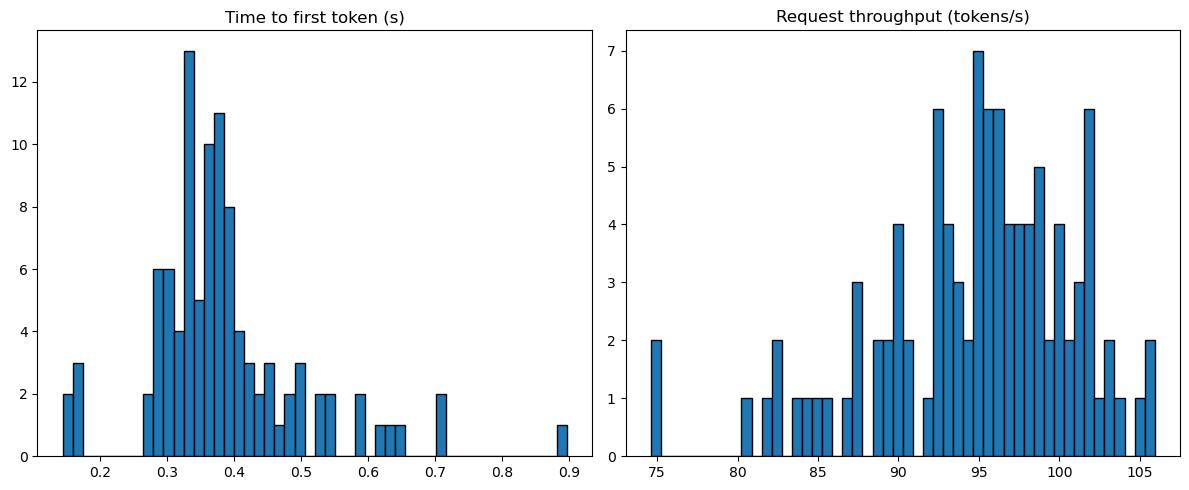

In [20]:
import matplotlib.pyplot as plt

ttft_values = [d["ttft_s"] for d in individual_responses if "ttft_s" in d]
throughput_values = [d["request_output_throughput_token_per_s"] for d in individual_responses if "request_output_throughput_token_per_s" in d]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(ttft_values, bins=50, edgecolor="black")
axes[0].set_title("Time to first token (s)")
axes[1].hist(throughput_values, bins=50, edgecolor="black")
axes[1].set_title("Request throughput (tokens/s)")
plt.tight_layout()
plt.show()

Feel free to edit the arguments of the `write_benchmarking_script` function to re-run the analysis for your specific scenario.

## Clean up

In [21]:
bedrock = boto3.client('bedrock', region_name=region)
response = bedrock.delete_imported_model(
    modelIdentifier=imported_model_name
)